# **Assignment To-Do**

Download the StanfordSentimentAnalysis Dataset from this link (Links to an 
external site.)(it might be troubling to download it, so force download on chrome). Use "datasetSentences.txt" and "sentiment_labels.txt" files from the zip you just downloaded as your dataset. This dataset contains just over 11,000 pieces of Stanford data from HTML files of Rotten Tomatoes. The sentiments are rated between 1 and 5, where one is the most negative and 5 is the most positive.

Train your model. Upload your collab file on GitHub with readme that contains details about your assignment/word (minimum 250 words), training logs showing final validation accuracy, and outcomes for 10 example inputs from the test/validation data.

**Importing all packages**

In [ ]:
import os
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()
import random
import torch, torchtext
from torchtext.legacy import data
import re 
import nltk
from nltk.tokenize import word_tokenize
from string import punctuation 
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# **Creating Data**


*   Reading all the files from StanfordSentimentAnalysis and merging them to get complete data 
*   Converting floating-point labels into 5 classes (0-0.2, 0.2-0.4, 0.4-0.6, 0.6-0.8, 0.8-1.0)  



In [ ]:
def create_label(label):
    if label <= 0.2: return 0
    if label <= 0.4: return 1
    if label <= 0.6: return 2
    if label <= 0.8: return 3
    return 4

## Sentiment label data
sentiment_labels = pd.read_csv("sentiment_labels.txt", names=['phrase_ids', 'labels'], sep="|", header=0)
sentiment_labels['labels'] = sentiment_labels['labels'].apply(create_label)
## sentence index and sentence
sentence_ids = pd.read_csv("datasetSentences.txt", sep="\t")
## phrases and phrase_ids
dic = pd.read_csv("dictionary.txt", sep="|", names=['phrase', 'phrase_ids'])
## Train Test split
train_test_valid_split = pd.read_csv("datasetSplit.txt")
## Merging data to create final data
sentence_phrase_merge = pd.merge(sentence_ids, dic, left_on='sentence', right_on='phrase')
sentence_phrase_split = pd.merge(sentence_phrase_merge, train_test_valid_split, on='sentence_index')
dataset = pd.merge(sentence_phrase_split, sentiment_labels, on='phrase_ids')
print("Length of data : ",dataset.shape[0])
## Subset data for Model
df = dataset[['labels','sentence']]
print('train data shape: ', df.shape)
df.head()


Length of data :  11286
train data shape:  (11286, 2)


,labels,sentence
0,3,The Rock is destined to be the 21st Century 's...
1,4,The gorgeously elaborate continuation of `` Th...
2,2,Effective but too-tepid biopic
3,3,If you sometimes like to go to the movies to h...
4,4,"Emerges as something rare , an issue movie tha..."


Text(0, 0.5, 'Label')

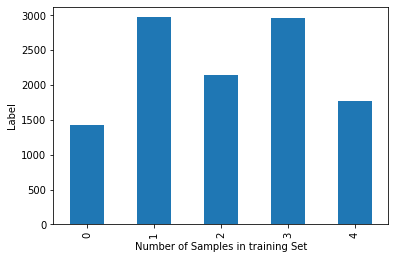

In [ ]:
ax = df['labels'].value_counts(sort=False).plot(kind='bar')
ax.set_xlabel("Number of Samples in training Set")
ax.set_ylabel("Label")

In [ ]:
# Manual Seed
SEED = 43
torch.manual_seed(SEED)

**Splitting data into train/test - 70/30 ratio**

In [ ]:
train_data,test_data = train_test_split(df,test_size=0.3)
train_data.reset_index(inplace=True)
test_data.reset_index(inplace=True)

**Basic Data Cleaning**

In [ ]:
def cleanup_text(texts):
    cleaned_text = []
    for text in texts:
        # remove punctuation
        text = re.sub('[^a-zA-Z0-9]', ' ', text)
        # remove multiple spaces
        text = re.sub(r' +', ' ', text)
        # remove newline
        text = re.sub(r'\n', ' ', text)
        text = str(text).lower()
        text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text) # remove URLs
        text = re.sub('@[^\s]+', 'ATUSER', text) # remove usernames
        text = re.sub(r'#([^\s]+)', r'\1', text) # remove the # in #hashtag
        text = re.sub('[^A-Za-z0-9]+', ' ', text) # remove # and numbers
        cleaned_text.append(text)
    return cleaned_text

In [ ]:
Text = torchtext.legacy.data.Field(preprocessing=cleanup_text, sequential = True, tokenize = 'spacy', batch_first =True, include_lengths=True)
Label = torchtext.legacy.data.LabelField(dtype = torch.int64)

In [ ]:
fields = [('sentence', Text),('labels',Label)]

In [ ]:
train_example = [data.Example.fromlist([train_data.sentence[i],train_data.labels[i]], fields) for i in range(train_data.shape[0])] 
test_example = [data.Example.fromlist([test_data.sentence[i],test_data.labels[i]], fields) for i in range(test_data.shape[0])] 

In [ ]:
train = data.Dataset(train_example, fields)
test = data.Dataset(test_example, fields)

In [ ]:
print(vars(train[0]))

{'sentence': ['this', 'slender', 'plot', 'feels', 'especially', 'thin', 'stretched', 'over', 'the', 'nearly', '80 minute', 'running', 'time', ' '], 'labels': 1}


In [ ]:
len(train), len(test)

(7839, 3360)

In [ ]:
Text.build_vocab(train,test,max_size=25000)
Label.build_vocab(train)
vocab_size = len(Text.vocab)

In [ ]:
print('Size of input vocab : ', len(Text.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Text.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  17289
Size of label vocab :  5
Top 10 words appreared repeatedly : [(' ', 27586), ('the', 9550), ('a', 6873), ('and', 5801), ('of', 5755), ('to', 4003), ('is', 3358), (' s', 3271), ('it', 3265), ('in', 2499)]
Labels :  defaultdict(None, {3: 0, 1: 1, 2: 2, 4: 3, 0: 4})


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_iterator, valid_iterator = torchtext.legacy.data.BucketIterator.splits((train, test), batch_size = 16, 
                                                            sort_key = lambda x: len(x.sentence),
                                                            sort_within_batch=True, device = device)

In [ ]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Text.vocab.stoi, tokens)

# **Model Architecture**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim1, hidden_dim2, output_dim, n_layers,
                 bidirectional, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.encoder = nn.LSTM(embedding_dim,
                            hidden_dim1,
                            num_layers=n_layers,
                            bidirectional=bidirectional,
                            batch_first=True)
        self.fc1 = nn.Linear(hidden_dim1*2 , hidden_dim2)
        self.fc2 = nn.Linear(hidden_dim2, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
        packed_output, (hidden, cell) = self.encoder(packed_embedded)

        cat = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        rel = self.relu(cat)
        dense1 = self.fc1(cat)
        drop = self.dropout(dense1)
        preds = self.fc2(drop)
        # Final activation function softmax
        output = F.softmax(preds, dim=1)
            
        return output

In [ ]:
lr = 1e-4
batch_size = 16
embedding_dim = 300
dropout_keep_prob = 0.5
seed = 42
output_dim = 5
hidden_dim1 = 512
hidden_dim2 = 256
n_layers = 2  # LSTM layers
bidirectional = False 
size_of_vocab = len(Text.vocab)
model = LSTM(size_of_vocab, embedding_dim, hidden_dim1, hidden_dim2, output_dim, n_layers, bidirectional, dropout_keep_prob)

In [ ]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

LSTM(
  (embedding): Embedding(17289, 300)
  (encoder): LSTM(300, 512, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=5, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 9,218,705 trainable parameters


In [ ]:
import torch.optim as optim

# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        sentence, text_lengths = batch.sentence
            
            # convert to 1d tensor
        predictions = model(sentence, text_lengths).squeeze()
        
        # compute the loss
        loss = criterion(predictions, batch.labels)        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.labels)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            sentence, text_lengths = batch.sentence
            
            # convert to 1d tensor
            predictions = model(sentence, text_lengths).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.labels)
            acc = binary_accuracy(predictions, batch.labels)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
N_EPOCHS = 10
best_valid_loss = float('inf')
tl = []
vl = []
ta = []
va = []

for epoch in range(N_EPOCHS):
     
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    tl.append(train_loss)
    ta.append(train_acc)
    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    vl.append(valid_loss)
    va.append(valid_acc)
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')

	Train Loss: 1.577 | Train Acc: 27.86%
	 Val. Loss: 1.564 |  Val. Acc: 30.89% 

	Train Loss: 1.539 | Train Acc: 34.75%
	 Val. Loss: 1.555 |  Val. Acc: 32.17% 

	Train Loss: 1.497 | Train Acc: 39.25%
	 Val. Loss: 1.552 |  Val. Acc: 31.70% 

	Train Loss: 1.456 | Train Acc: 43.77%
	 Val. Loss: 1.560 |  Val. Acc: 31.10% 

	Train Loss: 1.412 | Train Acc: 48.70%
	 Val. Loss: 1.559 |  Val. Acc: 32.38% 

	Train Loss: 1.373 | Train Acc: 52.67%
	 Val. Loss: 1.561 |  Val. Acc: 32.41% 

	Train Loss: 1.330 | Train Acc: 57.11%
	 Val. Loss: 1.571 |  Val. Acc: 31.87% 

	Train Loss: 1.297 | Train Acc: 60.59%
	 Val. Loss: 1.567 |  Val. Acc: 32.56% 

	Train Loss: 1.271 | Train Acc: 63.27%
	 Val. Loss: 1.575 |  Val. Acc: 31.43% 

	Train Loss: 1.253 | Train Acc: 65.10%
	 Val. Loss: 1.587 |  Val. Acc: 30.30% 



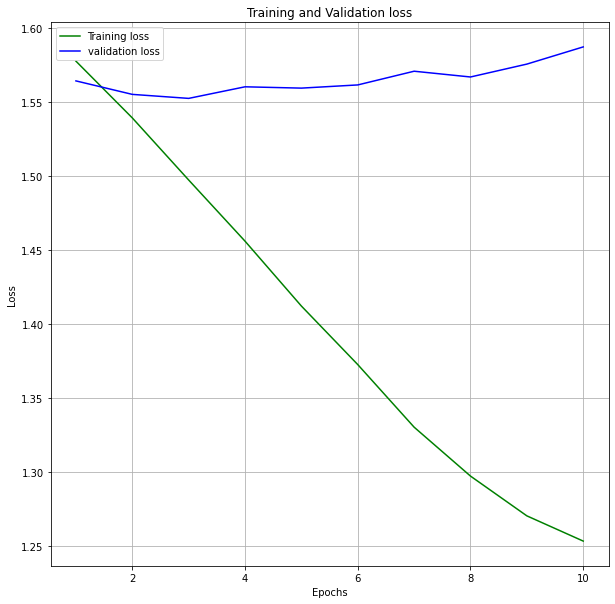

In [ ]:
#  training loss vs validation Accuracy
import matplotlib.pyplot as plt

epochs = range(1,11)
plt.plot(epochs, tl, 'g', label='Training loss')
plt.plot(epochs, vl, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

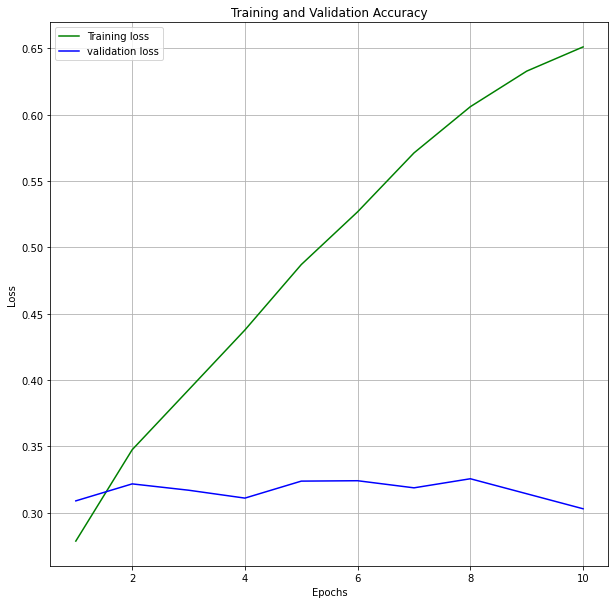

In [ ]:
#  training loss vs validation loss 
import matplotlib.pyplot as plt

epochs = range(1,11)
plt.plot(epochs, ta, 'g', label='Training loss')
plt.plot(epochs, va, 'b', label='validation loss')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:

model.eval();
tokenizer_file = open('tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

#inference 

import spacy
nlp = spacy.load('en')

def classify_text(tweet):
    
    categories = {0: "0", 1:"1", 2:"2", 3:"3", 4:"4"}
    
    # tokenize the tweet 
    tokenized = [tok.text for tok in nlp.tokenizer(tweet)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction = model(tensor, length_tensor)

    # _, pred = torch.max(prediction, 1) 
    pred = prediction.argmax(1, keepdim = True)
    
    return categories[pred.item()]

In [ ]:
train_data['pred'] = train_data['sentence'].apply(classify_text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test_data['pred'] = test_data['sentence'].apply(classify_text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


def plot_confusion_matrix(y_true, y_pred, 
                          classes=['Very Negative','Negative','Neutral','Positive','Very Positive'],
                          normalize=False,
                          cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    plt.figure(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', origin='lower', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # Show all ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # Label with respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Set alignment of tick labels
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    return fig, ax

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f60b1cd5990>)

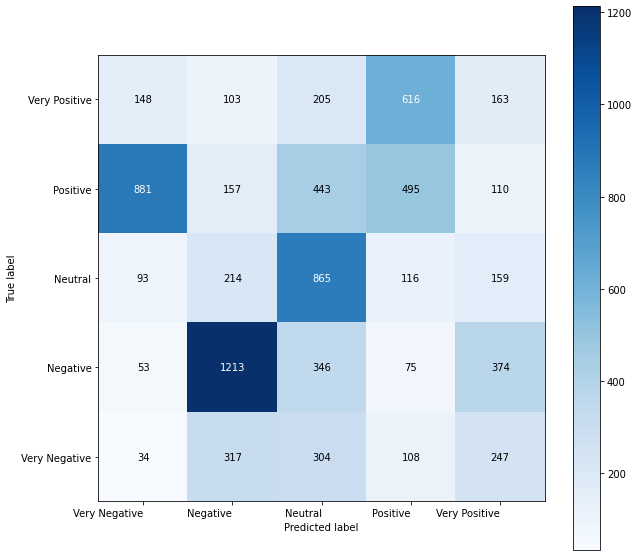

<Figure size 720x720 with 0 Axes>

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
plot_confusion_matrix(train_data['labels'].values.tolist(), train_data['pred'].astype(int).values.tolist())

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f60b1cd51d0>)

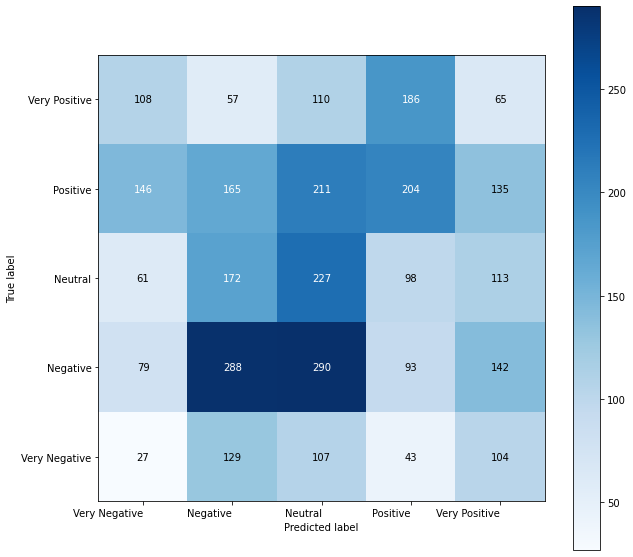

<Figure size 720x720 with 0 Axes>

In [ ]:
plot_confusion_matrix(test_data['labels'].values.tolist(), test_data['pred'].astype(int).values.tolist())

In [ ]:
SentimentClass = {0:'Very Negative', 1:'Negative', 2:'Neutral', 3:'Positive', 4:'Very Positive'}

test_data['pred'] = test_data['pred'].astype('int')
correctly_classified_texts = test_data[test_data['labels'] == test_data['pred']][:10]
print("*"*40)
print("***** Correctly Classified Text: *******")
print("*"*40)
for i, (index, row) in enumerate(correctly_classified_texts.iterrows()):
  print(f"{i+1}) Text: {row['sentence']}")
  print(f"   Target Sentiment: {SentimentClass[row['labels']]}")
  print(f"   Predicted Sentiment: {SentimentClass[row['pred']]}")
  print()

****************************************
***** Correctly Classified Text: *******
****************************************
1) Text: Remember when Bond had more glamour than clamor ?
   Target Sentiment: Negative
   Predicted Sentiment: Negative

2) Text: While Broomfield 's film does n't capture the effect of these tragic deaths on hip-hop culture , it succeeds as a powerful look at a failure of our justice system .
   Target Sentiment: Positive
   Predicted Sentiment: Positive

3) Text: A giddy and provocative sexual romp that has something to say .
   Target Sentiment: Positive
   Predicted Sentiment: Positive

4) Text: The soul-searching deliberateness of the film , although leavened nicely with dry absurdist wit , eventually becomes too heavy for the plot .
   Target Sentiment: Negative
   Predicted Sentiment: Negative

5) Text: The movie attempts to mine laughs from a genre -- the gangster\/crime comedy -- that wore out its welcome with audiences several years ago , and its cutesy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
SentimentClass = {0:'Very Negative', 1:'Negative', 2:'Neutral', 3:'Positive', 4:'Very Positive'}

test_data['pred'] = test_data['pred'].astype('int')
incorrectly_classified_texts = test_data[test_data['labels'] != test_data['pred']][:10]
print("*"*40)
print("***** Incorrectly Classified Text: *******")
print("*"*40)
for i, (index, row) in enumerate(incorrectly_classified_texts.iterrows()):
  print(f"{i+1}) Text: {row['sentence']}")
  print(f"   Target Sentiment: {SentimentClass[row['labels']]}")
  print(f"   Predicted Sentiment: {SentimentClass[row['pred']]}")
  print()

****************************************
***** Incorrectly Classified Text: *******
****************************************
1) Text: The unique niche of self-critical , behind-the-scenes navel-gazing Kaufman has carved from Orleans ' story and his own infinite insecurity is a work of outstanding originality .
   Target Sentiment: Very Positive
   Predicted Sentiment: Positive

2) Text: Though Avary has done his best to make something out of Ellis ' nothing novel , in the end , his Rules is barely worth following .
   Target Sentiment: Negative
   Predicted Sentiment: Very Negative

3) Text: Successfully blended satire , high camp and yet another sexual taboo into a really funny movie .
   Target Sentiment: Positive
   Predicted Sentiment: Very Negative

4) Text: Plays like a checklist of everything Rob Reiner and his cast were sending up .
   Target Sentiment: Neutral
   Predicted Sentiment: Very Positive

5) Text: A sentimental hybrid that could benefit from the spice of specificity 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
